In [56]:
import tensorflow as tf
import os
import numpy as np
from os import listdir
from PIL import Image
from sklearn.model_selection import train_test_split
import imageio
import cv2
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import SGD
from sklearn.model_selection import KFold
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:

imgSize = 64 #resize all images 64*64 pixels
numClasses = 10 #0->9
testSize = 0.2 #20% testing, 80%training


In [59]:
#get dataset 
dataset_path='/content/drive/MyDrive/Dataset'
l=listdir(dataset_path)
X = []
Y = []
for i, label in enumerate(l):
    # print(i,'  ',label)
    datas_path = dataset_path + '/' + label
    for data in listdir(datas_path):
        # print('** ',data)
        img = imageio.imread(datas_path + '/' + data, as_gray=False)
        img = cv2.resize(img, (imgSize,imgSize))
        X.append(img)
        Y.append(label)

164.48943083424265
4
1649


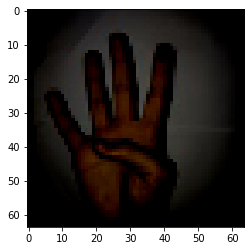

In [60]:
avg = np.average(X)
print(avg)
X = np.asarray(X)
X  = X.astype('float32')
X -= avg 
X /= 255

#Splitting 20% test , 80% Train
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


x_train = np.asarray(x_train)
x_test = np.asarray(x_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

#test image in train
plt.imshow(x_train[10])

#get its categorized value
print(y_train[10])
print(x_train.shape[0])

# Reshaping the array to 4-dimensions so that it can work with the Keras API
x_train = x_train.reshape((x_train.shape[0], imgSize, imgSize, 3))
x_test = x_test.reshape((x_test.shape[0], imgSize, imgSize, 3))

 #0,1,2,..9   

y_train = to_categorical(y_train, numClasses)
y_test = to_categorical(y_test, numClasses)






In [61]:
#Build CNN Model 1st Arch.

model = Sequential()

model.add(Conv2D(32, (5, 5), input_shape=(imgSize, imgSize, 3), activation='relu'))

model.add(MaxPooling2D())

model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dense(numClasses, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [62]:
# k-fold cross-validation during trianing
scores, histories = list(), list()
sum_ = 0.0
# prepare cross validation
K=4
kfold = KFold(K, shuffle=True, random_state=1)

# enumerate splits
for train_ix, val_ix in kfold.split(x_train):
    # select rows for train and test
    trainX, trainY, valX, valY = x_train[train_ix], y_train[train_ix], x_train[val_ix], y_train[val_ix]
    # fit model
    history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(valX, valY), verbose=0)
    # evaluate model
    _, acc = model.evaluate(valX, valY, verbose=0)
    # stores scores
    scores.append(acc)
    histories.append(history)
    sum_ += acc
scoreOfVal = sum_ / K

#TESTING ACCURACY 
_, scoreOfTest = model.evaluate(x_test, y_test, batch_size=32, verbose=0)

In [64]:

print('Validation Accuracy= ', scoreOfVal)
print('Testing Accuracy= ', scoreOfTest)

y_pred = model.predict(x_test)
# print(y_pred)


y_pred_=np.argmax(y_pred, axis=1)
y_test_=np.argmax(y_test, axis=1)
# print(y_test)


print(classification_report(y_test_, y_pred_))
print (confusion_matrix(y_test_, y_pred_))


# # Precision= TP/(TP + FP) = Accuracy of positive predictions.

# # Recall = TP/(TP+FN) = Fraction of positives that were correctly identified.

# # F1 Score = 2*(Recall * Precision) / (Recall + Precision) = What percent of positive predictions were correct? 

Validation Accuracy=  0.9503455609083176
Testing Accuracy=  0.8789346218109131
13/13 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.94      0.89      0.92        38
           1       0.96      0.94      0.95        48
           2       0.87      0.87      0.87        46
           3       0.94      0.91      0.93        35
           4       0.78      0.88      0.82        40
           5       0.98      0.94      0.96        50
           6       0.71      0.78      0.75        32
           7       0.86      0.77      0.81        39
           8       0.83      0.87      0.85        45
           9       0.90      0.90      0.90        40

    accuracy                           0.88       413
   macro avg       0.88      0.87      0.88       413
weighted avg       0.88      0.88      0.88       413

[[34  0  0  0  1  0  2  0  0  1]
 [ 1 45  1  0  0  0  0  1  0  0]
 [ 0  0 40  0  1  0  4  1  0  0]
 [ 0  0  2